# Homework 4: Artificial Neural Network and Deep Learning

## 2021-0407 CIS 600 Fundamental Data & Knowledge Mining

### Tanay Nagireddy

#### June 13th, 2021

**Problem Statement**

In this homework assignment, you are going to use multiple artificial neural networks and deep learning
models with different architectures to build disease diagnosis models using the same dataset in HW3. It is
a binary classification problem to predict whether or not a patient has a certain unspecified disease. You
also need to combine the findings with HW3 results to come up with a ranking of performance for various
machine learning models on this dataset.

Report layout: as a rough guide, include at the very least the report title (with the author name and
date information), an executive summary, introduction, the main body of your report (with analysis,
results and interpretation for each required machine learning algorithm), and a conclusion section that
provide a high level summary of your findings and any lessons learned.

**Introduction**

This assignment utilizes personal information containing patient data. The data includes whether or not that patient possesses the disease. Through the assignment we were be able to gather enough insight and tell whether existing patients that have not yet been examined for the disease, or incomming future patients, may have the disease.

**Executive Summary**

Four classifiers, three of which Artificial Neural Networks with varying hidden layers (0, 1, and 2) along with a Decision Tree Classifier are applied to patient data to be able to build a model that can identify whether an individual has a specific disease. From the analysis we can see that there is a tradeoff between computation and correct hyperparameter inputs. To test or iterate through many different hyperparameters efficiently, grid search was applied to find an approximation of the best hyperparameters. The dataset was cleansed of outliers by removing those that were statistically considered an outlier (greater than 3 z-score). This was done on continuous data along with other pre-processing steps. With the finalized dataset, each classifier was setup and produced an overall score between 70-75%. 

Although both ANN and Decision Tree almost identical scores, the ANN 0 hidden layers proved to have the most reliable predictions on the unseen test dataset, whereas Decision Tree was extremely skewed to the positive class. Additional insight can be gathered from the recall scores from ANN to more effectively compare the discrepancy between the results of these two classifiers.

### Libraries and Data

 * importing required libraries

In [1]:
# data
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# graphing
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import graphviz
from string import ascii_letters

# collection
from collections import Counter, OrderedDict, namedtuple
import itertools

# statistical
import math
from scipy import stats
from scipy.stats import normaltest, shapiro
import scipy.stats as ss

# modelling
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, classification_report, plot_confusion_matrix, plot_roc_curve, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB

# deep learning
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# plots visualizations below cell
%matplotlib inline

In [3]:
# ignore warnings that appear for HTML output
import warnings
warnings.simplefilter('ignore')

In [4]:
%%time
# import training and testing data
data_train = pd.read_csv("Disease Prediction Training.csv")
data_test = pd.read_csv("Disease Prediction Testing.csv")

Wall time: 53.9 ms


### Functions

The following functions provide a clean way to compute/conduct necessary data analysis, please see the function headers for information about each function.

In [5]:
def splitByType(df):
    """
    Description: computes two dataframes based on the type of the columns (int64, float64, object)
    Input: dataframe containing cleansed data
    Return: dataframe containing only object type columns, and dataframe excluding only object type columns 
    """
    non_object_type = df.select_dtypes(exclude=['object'])  # int64, float64, etc.
    object_type = df.select_dtypes(include=['object'])  # string, etc.
    return {'non_object_type':non_object_type, 'object_type':object_type}

In [6]:
def displayBoxPlots(df):
    """
    Description: plots the boxplots of features/attributes/columns
    Input: non_object_type dataframe (int64, float64, etc.) containing cleansed data
    Return: plot of box plots
    Reference: https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
    """
    l = df.columns.values
    number_of_columns=7
    number_of_rows = len(l)-1/number_of_columns
    plt.figure(figsize=(number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.set_style('whitegrid')
        sns.boxplot(y=df[l[i]],color='green',orient='v')
        plt.tight_layout()

In [7]:
def displayDistribution(df):
    """
    Description: plots the distribution plots/histograms of features/attributes/columns
    Input: non_object_type dataframe (int64, float64, etc.) containing cleansed data
    Return: plot of distribution plots/histograms
    Reference: https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
    """
    l = df.columns.values
    number_of_columns=7
    number_of_rows = len(l)-1/number_of_columns
    plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.distplot(df[l[i]],kde=True)

In [8]:
def displayCorrelationHeatMap(df_corr):
    """
    Description: display a correlation matrix for the dataframe of correlation values (depending on the statistic)
    Input: dataframe of correlation values
    Result: heatmap of correlation matrix
    Reference: https://towardsdatascience.com/heatmap-basics-with-pythons-seaborn-fb92ea280a6c
    """
    plt.figure(figsize=(20,12))

    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()

    sns.heatmap(corr, mask=mask, cmap='viridis', annot=True)

In [9]:
def discretize_data(df, columns_, number_of_bins={}):
    """
    Description: Converts continous data into descrete bins.
    Input: Dataframe, features/columns, number of bins for each column
    Output: Discretized dataset
    """
    data = df.copy()
    
    for ind in range(len(columns_)):
    
        discretizer = KBinsDiscretizer(
            n_bins=number_of_bins[columns_[ind]], 
            encode='ordinal', 
            strategy='uniform'
        )

        feature_data = data[columns_[ind]]
        
        est = discretizer.fit_transform(feature_data.values.reshape(-1, 1))
        
        data_train_discretize = pd.DataFrame(
            est, 
            columns=[columns_[ind]]
        )

        data_train_discretize.reset_index(inplace=True)

        data.drop(
            inplace=True,
            columns=columns_[ind]
        )

        data.reset_index(inplace=True)

        data = data.join(data_train_discretize, on='index', how='inner', lsuffix='_main', rsuffix='_disc')

        data.drop(columns=['index','index_main','index_disc'], inplace=True)
    
    return data

In [10]:
def model_implementation(classifier, df_train_test, param_grid):
    """
    Description: Implementations a model by training the model, and running it on the validation set
    Input: model type, dataset, dictionary of parameter values for gridsearch
    Output: Prints a series of information including metrics and results of model
    """
    X = df_train_test.drop(columns=['Disease'])

    y = df_train_test['Disease']

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        random_state=1,
        shuffle=True,
        stratify=y
    )

    print(f"Training data size is {X_train.shape}, and Validation data size is {X_test.shape}\n")
    
    models = {
        'GaussianNB':GaussianNB(),
        'BernoulliNB':BernoulliNB(),
        'MultinomialNB':MultinomialNB(),
        'ComplementNB':ComplementNB(),
        'KNeighborsClassifier':KNeighborsClassifier(),
        'RandomForestClassifier':RandomForestClassifier(),
        'GradientBoostingClassifier':GradientBoostingClassifier(),
        'DecisionTreeClassifier':DecisionTreeClassifier()
    }
    
    grid = GridSearchCV(
        models[classifier],
        param_grid, 
        cv=3,  # stratified k fold used for cross validation
        scoring=[
            'accuracy',
            'f1',
            'roc_auc'
        ],
        n_jobs=-1,
        refit='f1',
        verbose=2
    )
    
    grid.fit(X_train, y_train)
    
    print(f"Training set best score: {grid.best_score_}\n") # f1-score

    print("Best parameters found: \n", grid.best_params_)

    print("Fitting best params to validation data set... \n")
    
    if classifier == 'GaussianNB':
        clf = GaussianNB(**grid.best_params_)
    if classifier == 'BernoulliNB':
        clf = BernoulliNB(**grid.best_params_)
    if classifier == 'MultinomialNB':
        clf = MultinomialNB(**grid.best_params_)
    if classifier == 'ComplementNB':
        clf = ComplementNB(**grid.best_params_)
    if classifier == 'KNeighborsClassifier':
        clf = KNeighborsClassifier(**grid.best_params_)
    if classifier == 'RandomForestClassifier':
        clf = RandomForestClassifier(**grid.best_params_)
    if classifier == 'GradientBoostingClassifier':
        clf = GradientBoostingClassifier(**grid.best_params_)
    if classifier == 'DecisionTreeClassifier':
        clf = DecisionTreeClassifier(**grid.best_params_)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    
    if classifier == 'RandomForestClassifier':
        
        feature_imp = pd.DataFrame(
            clf.feature_importances_, index=X_train.columns,
            columns=['importance']
        ).sort_values('importance', ascending=False)
        
        print(feature_imp)
        
    if classifier == 'KNeighborsClassifier':
        
        neighbors = list(range(1, 50))
        train_results = []
        test_results = []
        for n in neighbors:
            model = KNeighborsClassifier(n_neighbors=n)
            model.fit(X_train, y_train)
            train_pred = model.predict(X_train)
            cv = KFold(n_splits=10, shuffle=True, random_state=16)  # repeated hold out accuracy
            acc = cross_val_score(model, X_train, y_train, cv=cv).mean()*100
            train_results.append(acc)
            y_pred = model.predict(X_test)
            acc_test = round(accuracy_score(y_test, y_pred)*100, 2)
            test_results.append(acc_test)

        line1, = plt.plot(neighbors, train_results, 'b', label="Train Accuracy")
        line2, = plt.plot(neighbors, test_results, 'r', label="Test Accuracy")
        plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.show()
    
    print("Fitting complete")
    
    print_scores(y_test, y_pred, y_pred_prob)
    
    plot_confusion_matrix(clf, X_test, y_test)
    
    plot_roc_curve(clf, X_test, y_test)
    
    return grid.best_params_

In [11]:
def print_scores(y_test,y_pred,y_pred_prob):
    '''
    Description: Prints varies scores that quantify an algorithms performance
    Input: Class label data and class probabilites
    Output: Scores
    '''
    print("\nConfusion matrix:\n", confusion_matrix(y_test,y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    print("\nRecall score: ", recall_score(y_test,y_pred))
    print("\nPrecision score: ", precision_score(y_test,y_pred))
    print("\nF1 score: ", f1_score(y_test,y_pred))
    print("\nAccuracy score: ", accuracy_score(y_test,y_pred))
    print("\nROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

## Data preparation

### Summary statistics

 * displaying descriptive statistics like data set dimensions, data types, column information

In [12]:
print(f"Training data: {data_train.shape} and Testing data: {data_test.shape}")

print("\nNumber of attributes: \n non_object_type: {} \n object_type: {}".format(len(splitByType(data_train)['non_object_type'].columns), len(splitByType(data_train)['object_type'].columns)))

print("\nNon-Object Type data:\n" , splitByType(data_train)['non_object_type'].columns)

print("\nObject Type data:\n" ,splitByType(data_train)['object_type'].columns)

print("\nData Types:\n", Counter(data_train.dtypes))

print("\nTraining data: \n", data_train.head())

print("\nTraining set information:\n")
print(data_train.info())


Training data: (49000, 12) and Testing data: (21000, 12)

Number of attributes: 
 non_object_type: 9 
 object_type: 3

Non-Object Type data:
 Index(['Age', 'Height', 'Weight', 'High Blood Pressure', 'Low Blood Pressure',
       'Smoke', 'Alcohol', 'Exercise', 'Disease'],
      dtype='object')

Object Type data:
 Index(['Gender', 'Cholesterol', 'Glucose'], dtype='object')

Data Types:
 Counter({dtype('int64'): 8, dtype('O'): 3, dtype('float64'): 1})

Training data: 
    Age  Gender  Height  Weight  High Blood Pressure  Low Blood Pressure  \
0   59  female     167    88.0                  130                  68   
1   64  female     150    71.0                  140                 100   
2   41  female     166    83.0                  100                  70   
3   50    male     172   110.0                  130                  80   
4   39  female     162    61.0                  110                  80   

  Cholesterol Glucose  Smoke  Alcohol  Exercise  Disease  
0      normal  norm

From this display of information, we can see that there is a mixture of categorical, continuous, and binary data.

**Missing Values**

In [13]:
print(f"\nThere are a total of {data_train.isna().sum().sum()} missing values.\n")

print(f"Here is a breakdown by column for missing values by column (# of columns = {len(data_train.isna().sum())}): \n")
print(data_train.isna().sum())


There are a total of 0 missing values.

Here is a breakdown by column for missing values by column (# of columns = 12): 

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
Disease                0
dtype: int64


There are no missing values which is great.

**Duplicate Values**

In [14]:
data_train.duplicated().sum()

1752

In [15]:
data_train.drop_duplicates(inplace=True)

In [16]:
data_train.duplicated().sum()

0

In [17]:
data_train.shape

(47248, 12)

In [18]:
data_train.reset_index(drop=True, inplace=True)

After checking for duplicate values, we removed the ones that were found from our training dataset.

**Mapping**
Training Set

We will map all categorical data to numerical data for both the training and test dataset.

In [19]:
mapped_columns = splitByType(data_train)['object_type'].columns

In [20]:
for col in mapped_columns:
    data_train[col] = data_train[col].astype('category')
    code_col = col + "_codes"
    data_train[code_col] = data_train[col].cat.codes

In [21]:
data_train.drop(columns=mapped_columns, inplace=True)

**Mapping**
Testing Set

In [22]:
mapped_columns = splitByType(data_test)['object_type'].columns

In [23]:
for col in mapped_columns:
    data_test[col] = data_test[col].astype('category')
    code_col = col + "_codes"
    data_test[code_col] = data_test[col].cat.codes

In [24]:
data_test.drop(columns=mapped_columns, inplace=True)

### Data Visualization

We will render visuals to gather insights on outliers and spread of the data.

In [25]:
data_train.describe(include='all')

Age        Height        Weight  High Blood Pressure  \
count  47248.000000  47248.000000  47248.000000         47248.000000   
mean      52.863126    164.352735     74.442470           129.013461   
std        6.791208      8.314608     14.469526           150.324461   
min       29.000000     55.000000     10.000000          -150.000000   
25%       48.000000    159.000000     65.000000           120.000000   
50%       53.000000    165.000000     72.000000           120.000000   
75%       58.000000    170.000000     82.000000           140.000000   
max       64.000000    207.000000    200.000000         14020.000000   

       Low Blood Pressure         Smoke       Alcohol      Exercise  \
count        47248.000000  47248.000000  47248.000000  47248.000000   
mean            97.557209      0.091411      0.056235      0.799378   
std            204.020137      0.288196      0.230378      0.400470   
min              0.000000      0.000000      0.000000      0.000000   
25%             80.000000      0.000000      0.000000      1.000000   
50%             80.000000      0.000000      0.000000      1.000000   
75%             90.000000      0.000000      0.000000      1.000000   
max          11000.000000      1.000000      1.000000      1.000000   

            Disease  Gender_codes  Cholesterol_codes  Glucose_codes  
count  47248.000000  47248.000000       47248.000000   47248.000000  
mean       0.509567      0.354999           0.976740       1.001587  
std        0.499914      0.478518           0.509554       0.393797  
min        0.000000      0.000000           0.000000       0.000000  
25%        0.000000      0.000000           1.000000       1.000000  
50%        1.000000      0.000000           1.000000       1.000000  
75%        1.000000      1.000000           1.000000       1.000000  
max        1.000000      1.000000           2.000000       2.000000

From the basic statistics, we can see that:
 * there are some odd min and max values for features like high and low blood pressure
 * from the means, we can see that smoking, exercise, alcohol, and gender are skewed to one end

Let's look at the spread of these values.

**Box Plots**

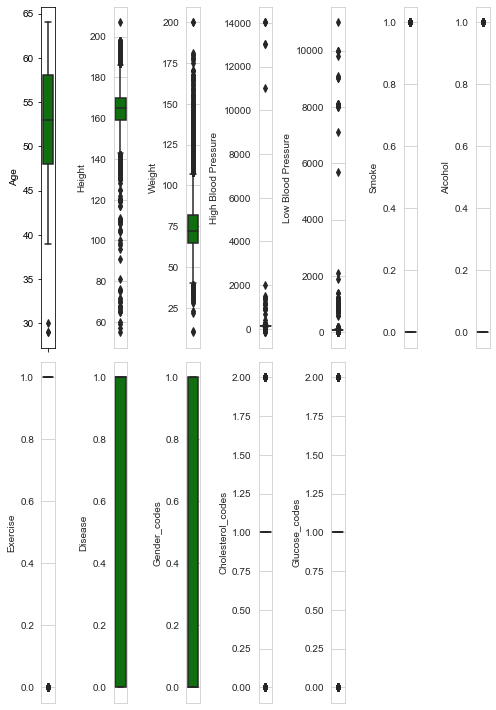

In [26]:
displayBoxPlots(data_train)

There are many outliers for features/attributes like high and low blood pressure, let's take a closer look and see how they can be handled.

**Unique Values**

In [27]:
for col in data_train.columns:
    print(data_train[col].value_counts())

55    2696
53    2575
57    2485
59    2436
56    2396
54    2396
49    2287
51    2280
58    2279
52    2162
60    2132
50    2129
63    1891
61    1888
64    1520
62    1503
47    1494
43    1429
45    1389
41    1297
48    1232
39    1174
40    1100
46    1095
44    1010
42     970
29       2
30       1
Name: Age, dtype: int64
165    3630
160    3220
170    3105
168    2923
164    2294
158    2201
162    2179
156    1888
169    1858
167    1746
163    1737
159    1409
172    1403
166    1355
157    1279
175    1234
155    1212
161    1204
174    1065
154    1002
171     935
178     831
176     802
152     802
173     754
150     730
153     729
180     595
151     438
177     337
179     283
149     249
182     218
148     205
185     164
147     143
181     137
184     115
183     113
146     105
145      98
186      73
187      54
144      47
188      37
140      36
143      34
189      26
190      26
120      25
142      21
141      14
198      11
130       9
191       8
192     

Rather than removing hundreds of data points that contain odd values as they are difficult to pinpoint, we are going to remove statistical outliers data rows in each of the continuous attributes through multiple rounds as seen in the following subsections.

***Round 1*** High and Low Blood Pressure

In [28]:
data_train.shape

(47248, 12)

In [29]:
data_out_rem_1 = data_train[(np.abs(stats.zscore(data_train['High Blood Pressure'])) < 3)]

In [30]:
data_out_rem_1 = data_out_rem_1[(np.abs(stats.zscore(data_out_rem_1['Low Blood Pressure'])) < 3)]

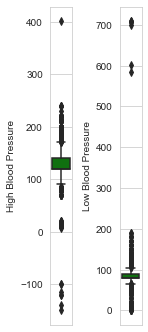

In [31]:
displayBoxPlots(data_out_rem_1[['High Blood Pressure', 'Low Blood Pressure']])

In [32]:
data_out_rem_1.shape

(46570, 12)

We can that some corrections has been done and data has been removed, but there are still some odd values, let's do another round.

***Round 2*** High and Low Blood Pressure

In [33]:
data_out_rem_2 = data_out_rem_1[(np.abs(stats.zscore(data_out_rem_1['High Blood Pressure'])) < 3)]

In [34]:
data_out_rem_2 = data_out_rem_2[(np.abs(stats.zscore(data_out_rem_2['Low Blood Pressure'])) < 3)]

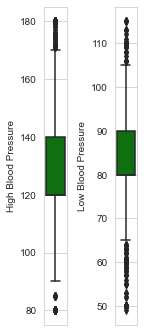

In [35]:
displayBoxPlots(data_out_rem_2[['High Blood Pressure', 'Low Blood Pressure']])

In [36]:
data_out_rem_2.shape

(46010, 12)

This is much better, we can move on to the other features.

#### *Height*

In [37]:
data_out_rem_3 = data_out_rem_2[(np.abs(stats.zscore(data_out_rem_2['Height'])) < 3)]

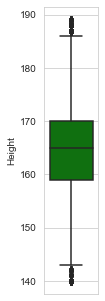

In [38]:
displayBoxPlots(data_out_rem_3[['Height']])

In [39]:
data_out_rem_3.shape

(45837, 12)

#### *Weight*

In [40]:
data_out_rem_4 = data_out_rem_3[(np.abs(stats.zscore(data_out_rem_3['Weight'])) < 3)]

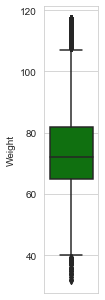

In [41]:
displayBoxPlots(data_out_rem_4[['Weight']])

In [42]:
data_out_rem_4.shape

(45424, 12)

#### *Age*

In [43]:
data_out_rem_5 = data_out_rem_4[(np.abs(stats.zscore(data_out_rem_4['Age'])) < 3)]

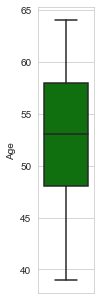

In [44]:
displayBoxPlots(data_out_rem_5[['Age']])

In [45]:
data_out_rem_5.shape

(45421, 12)

In [46]:
print(data_out_rem_5['Disease'].value_counts())

1    22742
0    22679
Name: Disease, dtype: int64


We can see that after removing the outliers, our class labels are extremely close which is great, meaning that this process has not created any skewness.

**Discretization**

We will not discretize the continuous features.

In [47]:
data_out_rem_5.reset_index(inplace=True, drop=True)

In [48]:
data_out_rem_5.head()

Age  Height  Weight  High Blood Pressure  Low Blood Pressure  Smoke  \
0   59     167    88.0                  130                  68      0   
1   64     150    71.0                  140                 100      0   
2   41     166    83.0                  100                  70      0   
3   50     172   110.0                  130                  80      1   
4   39     162    61.0                  110                  80      0   

   Alcohol  Exercise  Disease  Gender_codes  Cholesterol_codes  Glucose_codes  
0        0         1        0             0                  1              1  
1        0         0        1             0                  1              1  
2        1         1        0             0                  1              1  
3        0         1        0             1                  1              1  
4        0         1        0             0                  0              0

In [49]:
columns=[
    'Age',
    'Height', 
    'Weight',
    'High Blood Pressure',
    'Low Blood Pressure'
]

**Number of bins**

Using the freedman diaconis and the numpy method "histogram_bin_edges", we can decide the number of bins required for each attribute/feature.

In [50]:
print("Number of bins are as follows using the freedman diaconis estimator:\n")
num_of_bins = {}
for col in columns:
    bins = len(np.histogram_bin_edges(data_out_rem_5[col], bins='fd'))
    num_of_bins[col] = bins
print(num_of_bins)

Number of bins are as follows using the freedman diaconis estimator:

{'Age': 46, 'Height': 81, 'Weight': 91, 'High Blood Pressure': 91, 'Low Blood Pressure': 119}


**Descretization** Training Set

In [51]:
data_discretized = discretize_data(data_out_rem_5, columns_=columns, number_of_bins=num_of_bins)

In [52]:
data_discretized.head()

Smoke  Alcohol  Exercise  Disease  Gender_codes  Cholesterol_codes  \
0      0        0         1        0             0                  1   
1      0        0         0        1             0                  1   
2      0        1         1        0             0                  1   
3      1        0         1        0             1                  1   
4      0        0         1        0             0                  0   

   Glucose_codes   Age  Height  Weight  High Blood Pressure  \
0              1  36.0    44.0    59.0                 45.0   
1              1  45.0    16.0    41.0                 54.0   
2              1   3.0    42.0    54.0                 18.0   
3              1  20.0    52.0    83.0                 45.0   
4              0   0.0    36.0    31.0                 27.0   

   Low Blood Pressure  
0                34.0  
1                91.0  
2                37.0  
3                55.0  
4                55.0

**Descretization** Testing Set

In [53]:
print("Number of bins are as follows using the freedman diaconis estimator:\n")
num_of_bins = {}
for col in columns:
    bins = len(np.histogram_bin_edges(data_test[col], bins='fd'))
    num_of_bins[col] = bins
print(num_of_bins)

Number of bins are as follows using the freedman diaconis estimator:

{'Age': 50, 'Height': 235, 'Weight': 133, 'High Blood Pressure': 11044, 'Low Blood Pressure': 11823}


In [54]:
data_discretized_test = discretize_data(data_test, columns_=columns, number_of_bins=num_of_bins)

Let's see how the data looks post outlier removal and discretization.

**Distribution Plots**

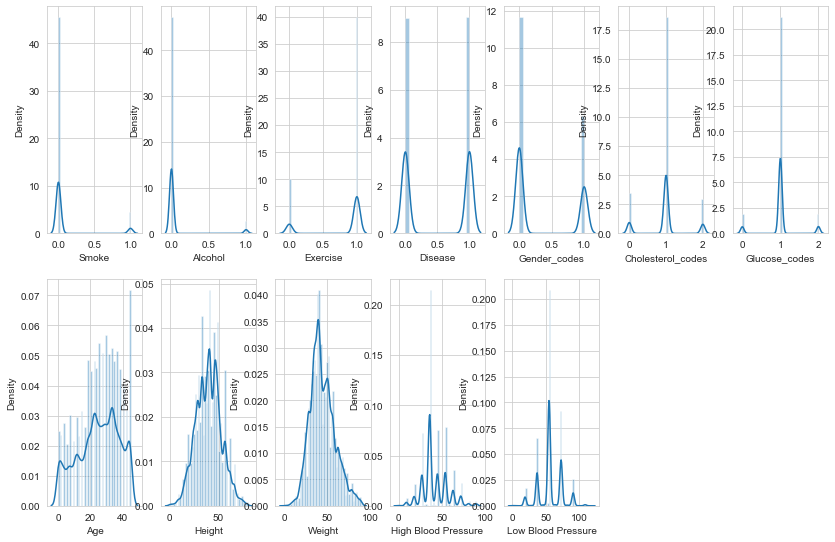

In [55]:
displayDistribution(data_discretized)

We can see that none of the features/attributes follow a gaussian-like distribution. Additionally, the disproportion of attributes is clearly visible, smoke, alcohol, exercise, gender_codes.

**Correlation Heat Maps**

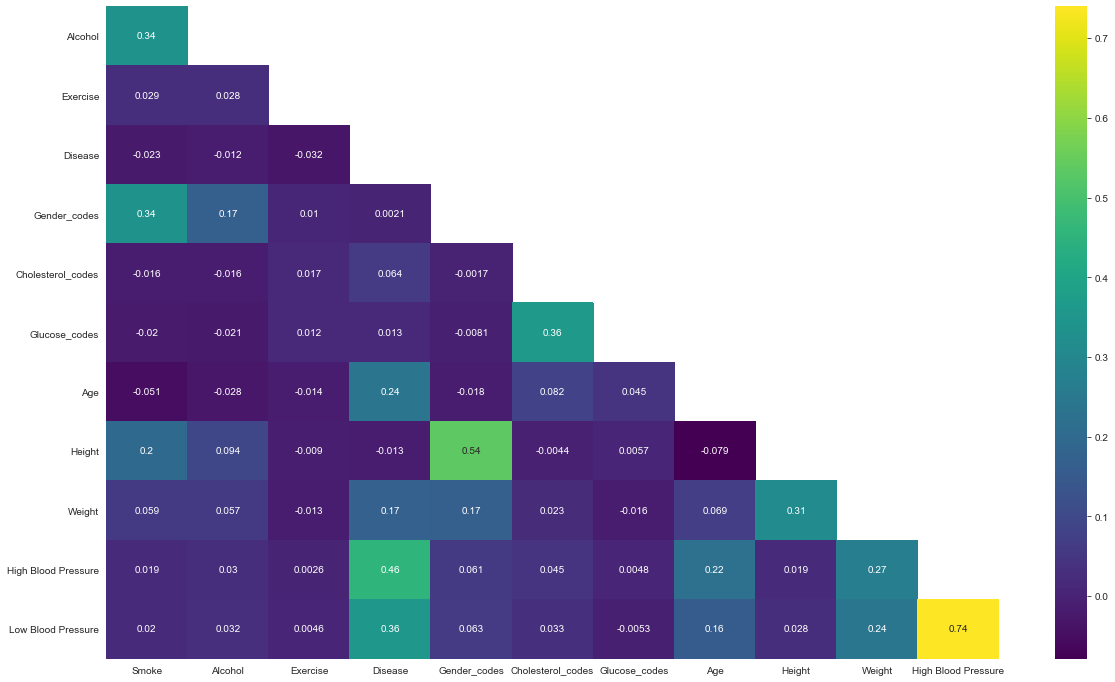

In [56]:
displayCorrelationHeatMap(data_discretized.corr(method='spearman'))

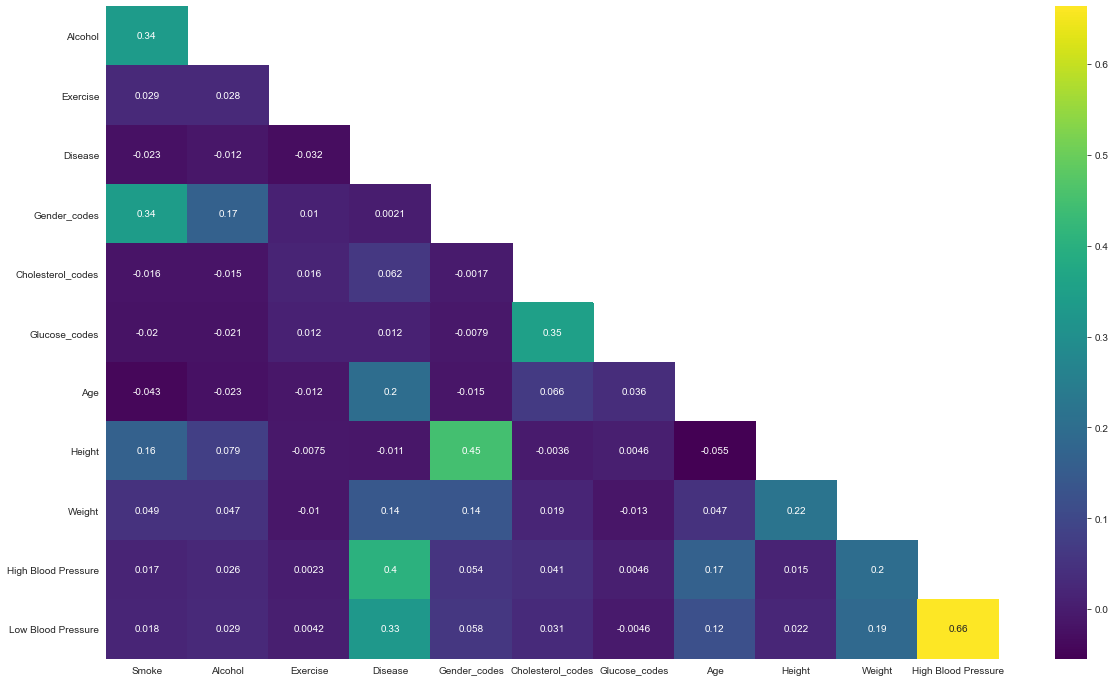

In [57]:
displayCorrelationHeatMap(data_discretized.corr(method='kendall'))

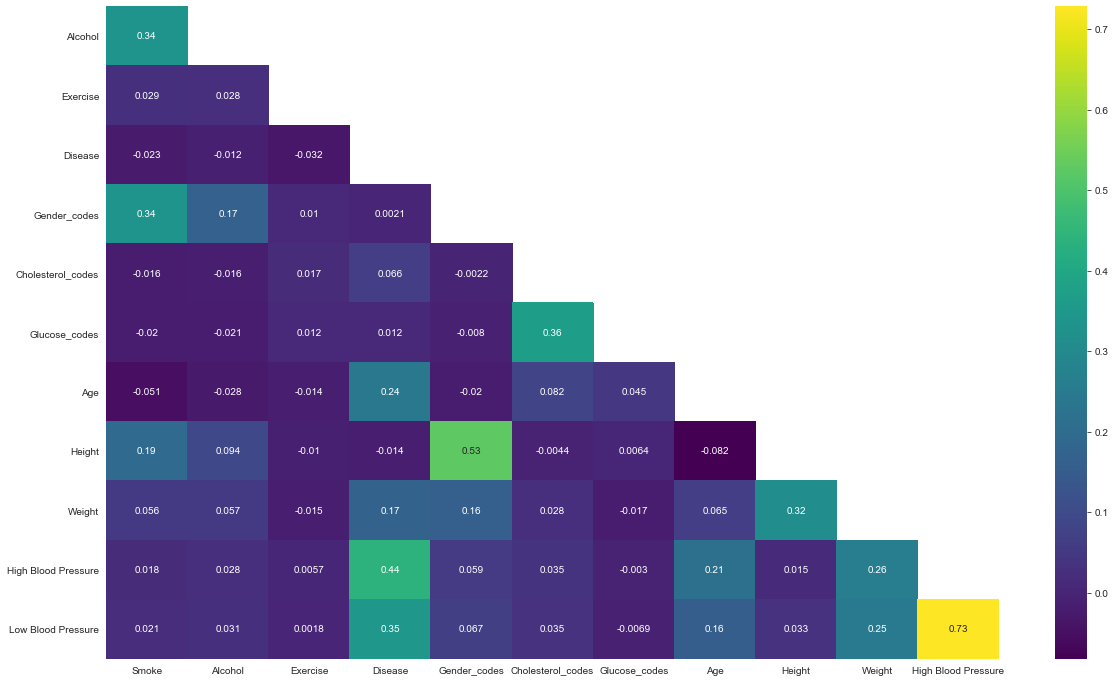

In [58]:
displayCorrelationHeatMap(data_discretized.corr(method='pearson'))

Through all the different methods, we can consistently see that some of the features/attributes have a strong correlation: 
 * A strong correlation between low and high blood pressure, not too surprising
 * Height and gender_codes seem to be correlated
 
These results suggest that a couple features my be disregarded/dropped.

**Pair Plots**

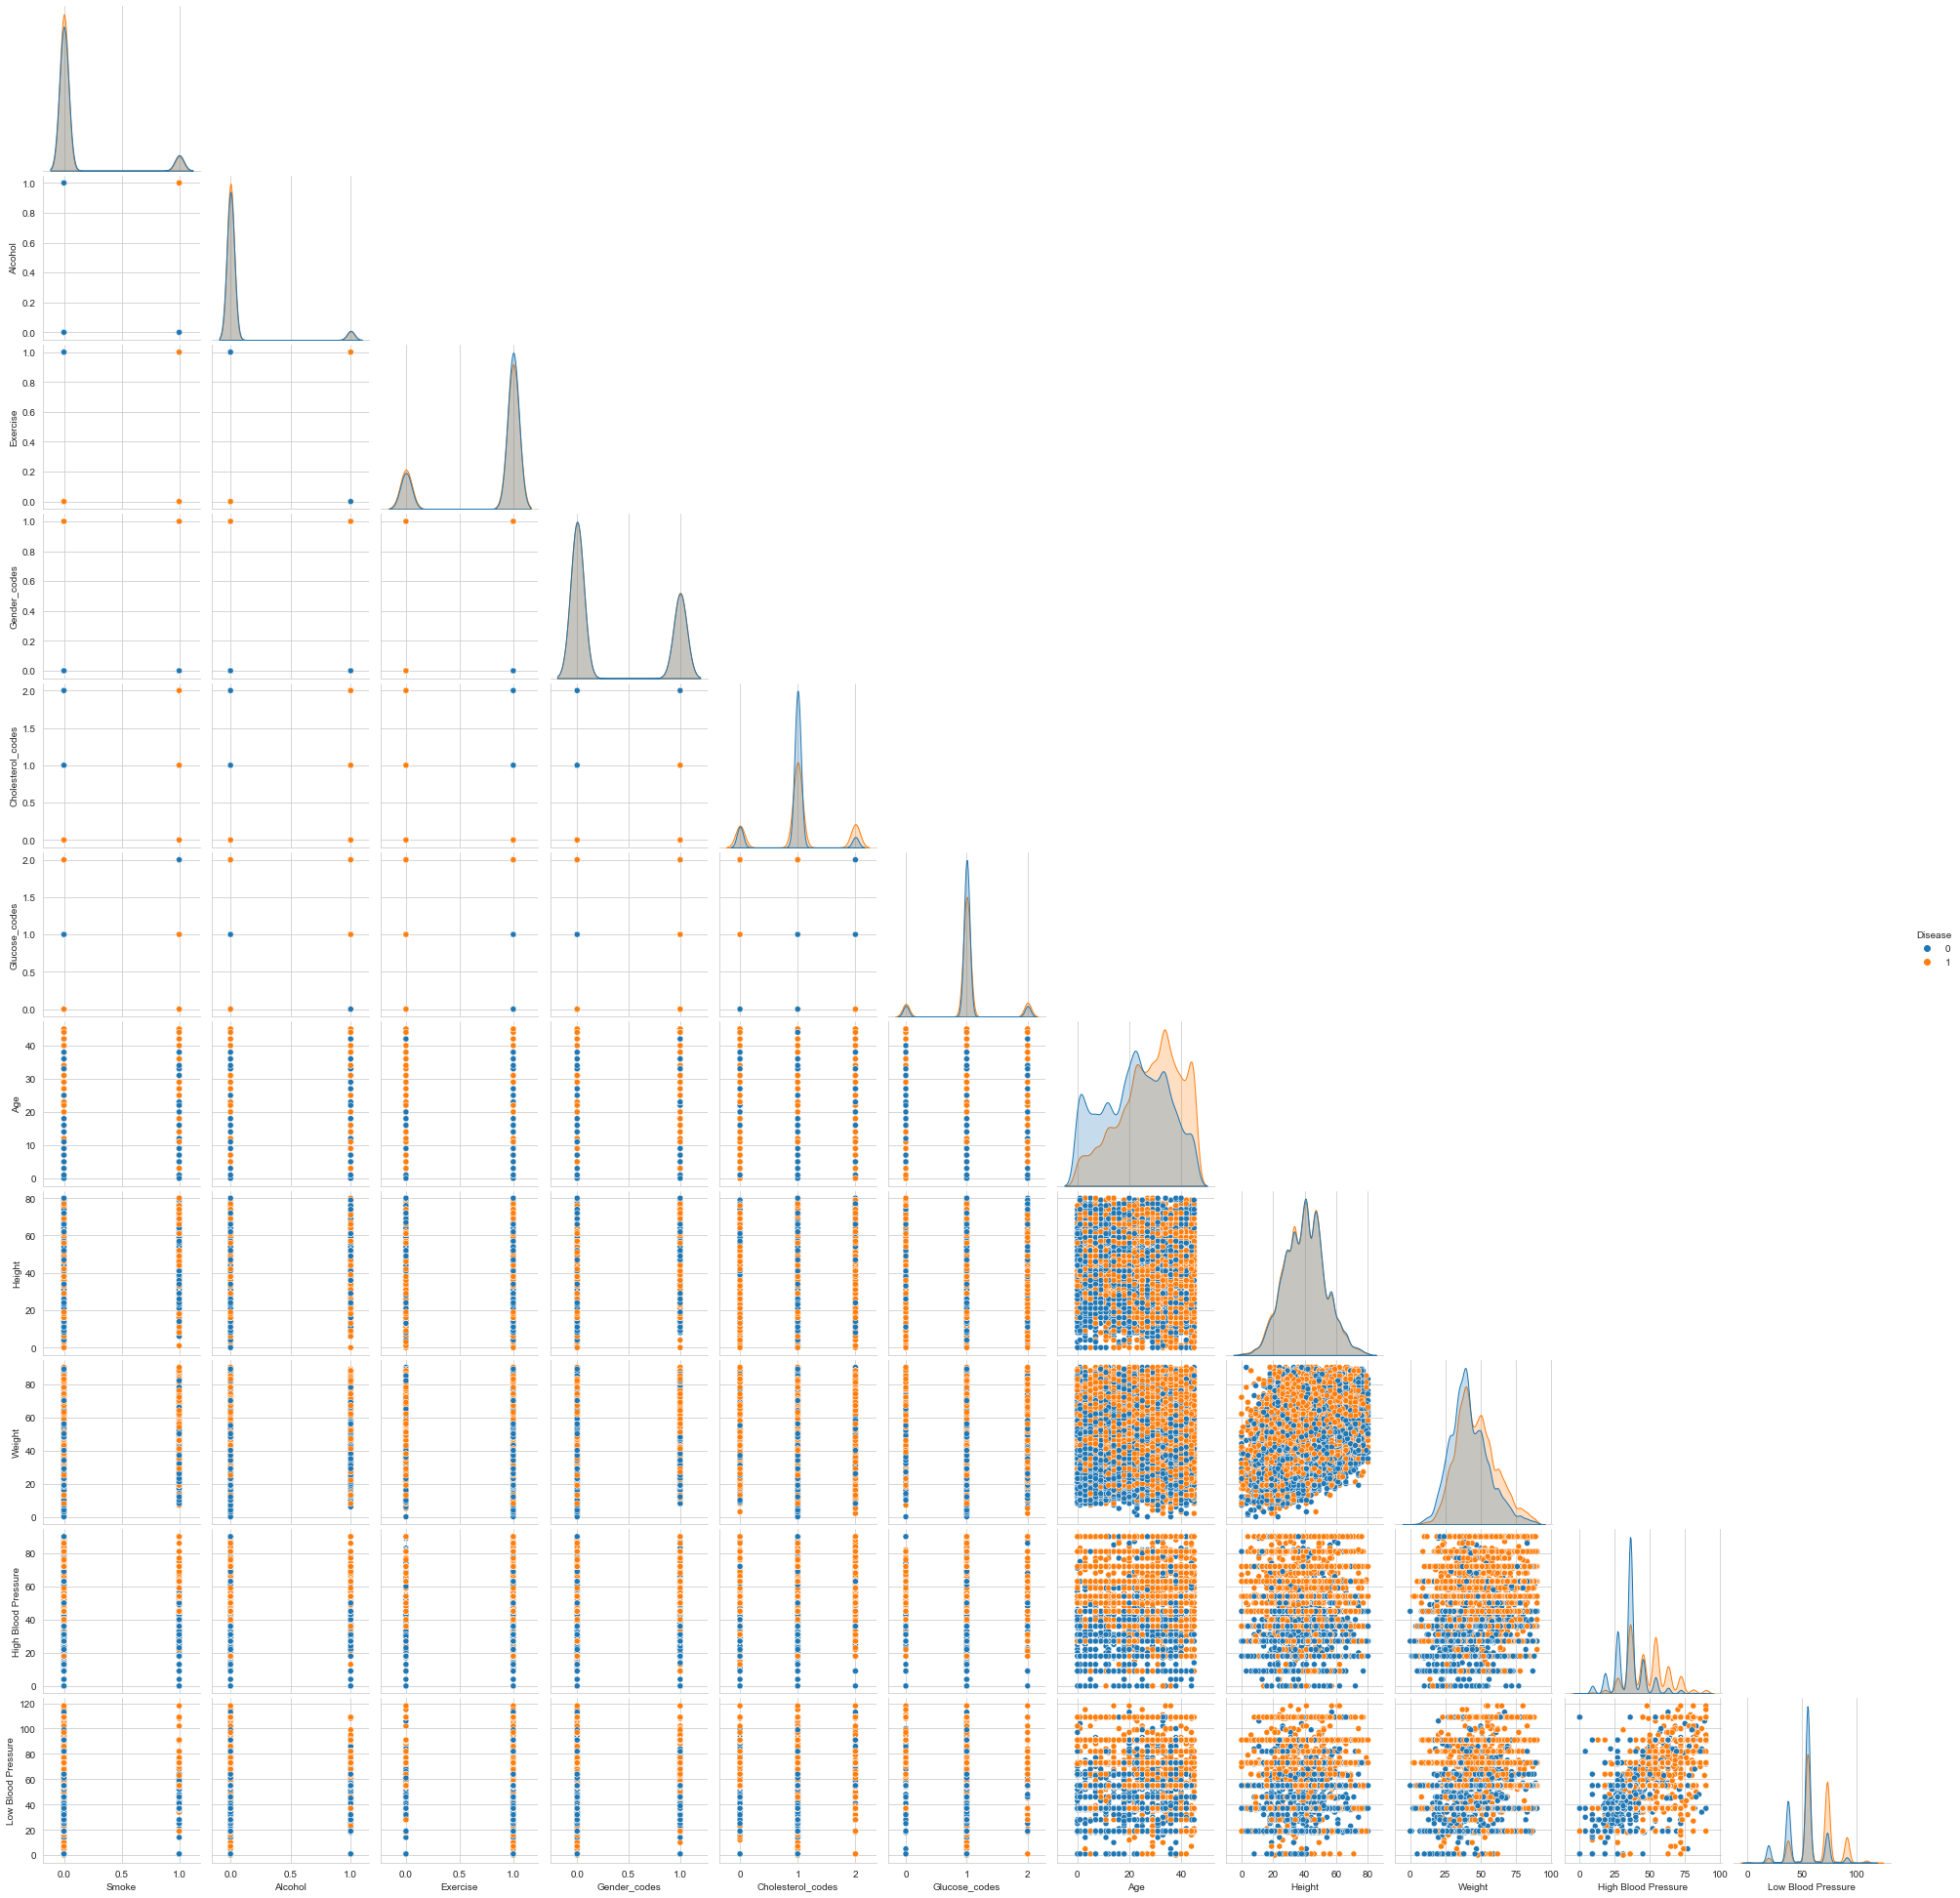

In [59]:
sns.pairplot(data_discretized, hue="Disease", corner=True)

From the pairplots we can see that there are distinctions between those that do have the disease and those that do not:
 * age - which shows a slight distinction with more older people having the disease rather than younger people. 
 * exercise - no exercise has far fewer people with the disease
 * smoke - follows exercise, no smoke with fewer people having the disease

Overall, there is a overlap between both of the disease classes.

**Feature Scaling - Standardization**

**Standardization** Training Set

In [60]:
standardized_est = StandardScaler().fit_transform(data_discretized)

data_standardized = pd.DataFrame(standardized_est, columns=data_discretized.columns)

data_standardized['Disease'] = data_standardized['Disease'].astype(int).map({-1:0,0:1})

data_standardized.head()

Smoke   Alcohol  Exercise  Disease  Gender_codes  Cholesterol_codes  \
0 -0.315714 -0.241394  0.501334        0     -0.737910           0.044688   
1 -0.315714 -0.241394 -1.994677        1     -0.737910           0.044688   
2 -0.315714  4.142600  0.501334        0     -0.737910           0.044688   
3  3.167420 -0.241394  0.501334        0      1.355178           0.044688   
4 -0.315714 -0.241394  0.501334        0     -0.737910          -1.931735   

   Glucose_codes       Age    Height    Weight  High Blood Pressure  \
0      -0.006592  0.884184  0.324937  1.034510             0.221365   
1      -0.006592  1.606408 -1.858042 -0.226986             0.842481   
2      -0.006592 -1.763969  0.169010  0.684094            -1.641982   
3      -0.006592 -0.399769  0.948645  2.716503             0.221365   
4      -2.565853 -2.004711 -0.298771 -0.927817            -1.020866   

   Low Blood Pressure  
0           -1.392946  
1            2.045097  
2           -1.211996  
3           -0.126298  
4           -0.126298

In [61]:
data_discretized.head()

Smoke  Alcohol  Exercise  Disease  Gender_codes  Cholesterol_codes  \
0      0        0         1        0             0                  1   
1      0        0         0        1             0                  1   
2      0        1         1        0             0                  1   
3      1        0         1        0             1                  1   
4      0        0         1        0             0                  0   

   Glucose_codes   Age  Height  Weight  High Blood Pressure  \
0              1  36.0    44.0    59.0                 45.0   
1              1  45.0    16.0    41.0                 54.0   
2              1   3.0    42.0    54.0                 18.0   
3              1  20.0    52.0    83.0                 45.0   
4              0   0.0    36.0    31.0                 27.0   

   Low Blood Pressure  
0                34.0  
1                91.0  
2                37.0  
3                55.0  
4                55.0

**Standardization** Testing Set

In [62]:
id_ = data_discretized_test['ID']

data_discretized_test.drop(columns=['ID'], inplace=True)

In [63]:
standardized_est_test = StandardScaler().fit_transform(data_discretized_test)

data_standardized_test = pd.DataFrame(standardized_est_test, columns=data_discretized_test.columns)

#data_standardized_test['Disease'] = data_standardized['Disease'].astype(int).map({-1:0,0:1})

#data_discretized_test['ID'] = id_
#data_standardized_test['ID'] = id_

data_standardized_test.head()

Smoke   Alcohol  Exercise  Gender_codes  Cholesterol_codes  \
0 -0.310262 -0.235785  0.492249     -0.732494          -1.955961   
1 -0.310262 -0.235785  0.492249     -0.732494           0.037689   
2 -0.310262 -0.235785  0.492249      1.365198           0.037689   
3 -0.310262 -0.235785 -2.031490     -0.732494           0.037689   
4 -0.310262 -0.235785  0.492249     -0.732494           0.037689   

   Glucose_codes       Age    Height    Weight  High Blood Pressure  \
0      -0.005758 -1.303867 -0.508442 -1.026790            -0.167478   
1      -0.005758 -1.718916  0.553839 -0.020290            -0.055293   
2      -2.578414  1.497715  0.457268  0.650711            -0.055293   
3      -0.005758  0.356330 -0.798155  2.328211             0.186335   
4      -0.005758  0.356330  0.360697 -0.523540            -0.055293   

   Low Blood Pressure  
0           -0.102552  
1           -0.162464  
2           -0.102552  
3            0.026489  
4           -0.102552

In [64]:
data_discretized_test.head()

Smoke  Alcohol  Exercise  Gender_codes  Cholesterol_codes  Glucose_codes  \
0      0        0         1             0                  0              1   
1      0        0         1             0                  1              1   
2      0        0         1             1                  1              0   
3      0        0         0             0                  1              1   
4      0        0         1             0                  1              1   

    Age  Height  Weight  High Blood Pressure  Low Blood Pressure  
0  21.0   121.0    31.0                 62.0               206.0  
1  17.0   132.0    43.0                 75.0               193.0  
2  48.0   131.0    51.0                 75.0               206.0  
3  37.0   118.0    71.0                103.0               234.0  
4  37.0   130.0    37.0                 75.0               206.0

We will now build and evaluate four classifiers, 3 arificial neural network models (0, 1, and 2 hidden layers) and finally, decision tree.

## Artificial Neural Networks (ANN)

We can summarize the types of layers in a Multi-Layer Preceptron (MLP) as follows (referenced from machinelearningmastery.com):

 * Input Layer: Input variables, sometimes called the visible layer.
 * Hidden Layers: Layers of nodes between the input and output layers. There may be one or more of these layers.
 * Output Layer: A layer of nodes that produce the output variables.
 * Finally, there are terms used to describe the shape and capability of a neural network; for example:

* Size: The number of nodes in the model.
* Width: The number of nodes in a specific layer.
* Depth: The number of layers in a neural network.
* Capacity: The type or structure of functions that can be learned by a network configuration. Sometimes called “representational capacity“.
* Architecture: The specific arrangement of the layers and nodes in the network.

We will be using the sigmoid activation function for the output layer as this makes it easy to obtain the final prediction value (0 or 1).

**Split Data Set (Train-Test Split)**

In [65]:
X = data_standardized.drop(columns=['Disease'])

y = data_standardized['Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1,
    shuffle=True,
    stratify=y
)

In [66]:
X_train.shape

(36336, 11)

In [67]:
y_train.shape

(36336,)

In [68]:
X_test.shape

(9085, 11)

In [69]:
y_test.shape

(9085,)

### Zero Layer ANN

In [70]:
def create_model_0(optimizer='adam', activation='relu'):
    """
    Description: sets up a neural network model to be passed into the Keras classifier
    Input: optimizer algorithm, activation function, and number of neurons
    Output: 2-layered model with an input layer, and an output layer
    Reference: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
    """
    
    # create the model
    model = Sequential()
    model.add(Dense(11, input_dim=11, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [71]:
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
activation = ['relu', 'tanh', 'sigmoid','linear']
#neurons = [1, 5, 10, 15, 20, 25, 30]

In [72]:
model = KerasClassifier(build_fn=create_model_0, epochs=15, batch_size=5, verbose=2)

In [73]:
param_grid = dict(optimizer=optimizer, activation=activation)

In [74]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=3)

In [75]:
grid.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Epoch 1/15
7268/7268 - 2s - loss: 0.5679 - accuracy: 0.7187
Epoch 2/15
7268/7268 - 2s - loss: 0.5544 - accuracy: 0.7298
Epoch 3/15
7268/7268 - 2s - loss: 0.5534 - accuracy: 0.7315
Epoch 4/15
7268/7268 - 2s - loss: 0.5527 - accuracy: 0.7323
Epoch 5/15
7268/7268 - 2s - loss: 0.5526 - accuracy: 0.7308
Epoch 6/15
7268/7268 - 2s - loss: 0.5523 - accuracy: 0.7330
Epoch 7/15
7268/7268 - 2s - loss: 0.5522 - accuracy: 0.7317
Epoch 8/15
7268/7268 - 2s - loss: 0.5517 - accuracy: 0.7310
Epoch 9/15
7268/7268 - 2s - loss: 0.5520 - accuracy: 0.7311
Epoch 10/15
7268/7268 - 2s - loss: 0.5518 - accuracy: 0.7324
Epoch 11/15
7268/7268 - 2s - loss: 0.5515 - accuracy: 0.7307
Epoch 12/15
7268/7268 - 2s - loss: 0.5516 - accuracy: 0.7316
Epoch 13/15
7268/7268 - 2s - loss: 0.5513 - accuracy: 0.7303
Epoch 14/15
7268/7268 - 2s - loss: 0.5514 - accuracy: 0.7324
Epoch 15/15
7268/7268 - 2s - loss: 0.5516 - accuracy: 0.7319


GridSearchCV(cv=2,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002BAB47C19D0>,
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'sigmoid', 'linear'],
                         'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam']},
             verbose=3)

In [76]:
grid.best_params_

{'activation': 'relu', 'optimizer': 'RMSprop'}

In [77]:
grid.best_estimator_

In [78]:
%%time
model = create_model_0(**grid.best_params_)

Wall time: 16 ms


In [80]:
print(f"Train vs Test Loss is: {min(history.history['loss'])} -- {min(history.history['val_loss'])}")
print(f"Train vs Test Accuracy is: {max(history.history['accuracy'])} -- {max(history.history['val_accuracy'])}")

Train vs Test Loss is: 0.5440595149993896 -- 0.5533098578453064
Train vs Test Accuracy is: 0.7351662516593933 -- 0.7312052845954895


In [81]:
%%time
model.evaluate(X_test, y_test, batch_size=10)

909/909 [==============================] - 0s 335us/step - loss: 0.5547 - accuracy: 0.7287
Wall time: 910 ms


[0.5546777844429016, 0.7286736369132996]

In [82]:
predictions = model.predict(data_standardized_test)
y_pred_ann0 = [round(x[0]) for x in predictions]

### One Layer ANN 

In [83]:
def create_model_1(optimizer='adam', activation='relu', neurons=2):
    """
    Description: sets up a neural network model to be passed into the Keras classifier
    Input: optimizer algorithm, activation function, and number of neurons
    Output: 3-layered model with an input layer, one hidden layer, and an output layer
    Reference: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
    """    
    # create the model
    model = Sequential()
    model.add(Dense(11, input_dim=11, activation=activation))
    model.add(Dense(neurons, activation=activation))  # one hidden layer
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [84]:
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
activation = ['relu', 'tanh', 'sigmoid']
neurons = [1, 5, 10, 15, 20, 25, 30]

In [85]:
model = KerasClassifier(build_fn=create_model_1, epochs=15, batch_size=5, verbose=2)

In [86]:
param_grid = dict(optimizer=optimizer, activation=activation, neurons=neurons)

In [87]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=3)

In [88]:
grid.fit(X_train, y_train)

Fitting 2 folds for each of 84 candidates, totalling 168 fits
Epoch 1/15
7268/7268 - 3s - loss: 0.5611 - accuracy: 0.7210
Epoch 2/15
7268/7268 - 3s - loss: 0.5539 - accuracy: 0.7258
Epoch 3/15
7268/7268 - 3s - loss: 0.5501 - accuracy: 0.7269
Epoch 4/15
7268/7268 - 3s - loss: 0.5481 - accuracy: 0.7284
Epoch 5/15
7268/7268 - 3s - loss: 0.5471 - accuracy: 0.7301
Epoch 6/15
7268/7268 - 3s - loss: 0.5465 - accuracy: 0.7304
Epoch 7/15
7268/7268 - 3s - loss: 0.5456 - accuracy: 0.7305
Epoch 8/15
7268/7268 - 3s - loss: 0.5453 - accuracy: 0.7312
Epoch 9/15
7268/7268 - 3s - loss: 0.5451 - accuracy: 0.7323
Epoch 10/15
7268/7268 - 3s - loss: 0.5451 - accuracy: 0.7315
Epoch 11/15
7268/7268 - 3s - loss: 0.5445 - accuracy: 0.7331
Epoch 12/15
7268/7268 - 3s - loss: 0.5448 - accuracy: 0.7329
Epoch 13/15
7268/7268 - 3s - loss: 0.5447 - accuracy: 0.7330
Epoch 14/15
7268/7268 - 3s - loss: 0.5445 - accuracy: 0.7338
Epoch 15/15
7268/7268 - 3s - loss: 0.5450 - accuracy: 0.7333


GridSearchCV(cv=2,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002BAC5011B80>,
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'sigmoid'],
                         'neurons': [1, 5, 10, 15, 20, 25, 30],
                         'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam']},
             verbose=3)

In [89]:
grid.best_params_

{'activation': 'tanh', 'neurons': 10, 'optimizer': 'RMSprop'}

In [90]:
grid.best_estimator_

In [91]:
%%time
model = create_model_1(**grid.best_params_)

Wall time: 21 ms


In [93]:
print(f"Train vs Test Loss is: {min(history.history['loss'])} -- {min(history.history['val_loss'])}")
print(f"Train vs Test Accuracy is: {max(history.history['accuracy'])} -- {max(history.history['val_accuracy'])}")

Train vs Test Loss is: 0.5408302545547485 -- 0.5472914576530457
Train vs Test Accuracy is: 0.7359368205070496 -- 0.7301045656204224


In [94]:
%%time
model.evaluate(X_test, y_test, batch_size=10)

909/909 [==============================] - 0s 319us/step - loss: 0.5526 - accuracy: 0.7244
Wall time: 894 ms


[0.552615761756897, 0.7243808507919312]

In [95]:
predictions = model.predict(data_standardized_test)
y_pred_ann1 = [round(x[0]) for x in predictions]

### Two Layer ANN

In [96]:
def create_model_2(optimizer='adam', activation='relu', neurons=2):
    """
    Description: sets up a neural network model to be passed into the Keras classifier
    Input: optimizer algorithm, activation function, and number of neurons
    Output: 4-layered model with an input layer, two hidden layers, and an output layer
    Reference: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
    """
    
    # create the model
    model = Sequential()
    model.add(Dense(11, input_dim=11, activation=activation))
    model.add(Dense(neurons, activation=activation))  # one hidden layer
    model.add(Dense(neurons, activation=activation))  # another hidden layer
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [97]:
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
activation = ['relu', 'tanh', 'sigmoid']
neurons = [1, 5, 10, 15, 20, 25, 30]

In [98]:
model = KerasClassifier(build_fn=create_model_2, epochs=15, batch_size=5, verbose=2)

In [99]:
param_grid = dict(optimizer=optimizer, activation=activation, neurons=neurons)

In [100]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=3)

In [101]:
grid.fit(X_train, y_train)

Fitting 2 folds for each of 84 candidates, totalling 168 fits
Epoch 1/15
7268/7268 - 3s - loss: 0.5655 - accuracy: 0.7175
Epoch 2/15
7268/7268 - 3s - loss: 0.5476 - accuracy: 0.7286
Epoch 3/15
7268/7268 - 3s - loss: 0.5447 - accuracy: 0.7305
Epoch 4/15
7268/7268 - 3s - loss: 0.5436 - accuracy: 0.7311
Epoch 5/15
7268/7268 - 3s - loss: 0.5428 - accuracy: 0.7331
Epoch 6/15
7268/7268 - 3s - loss: 0.5425 - accuracy: 0.7335
Epoch 7/15
7268/7268 - 3s - loss: 0.5415 - accuracy: 0.7339
Epoch 8/15
7268/7268 - 3s - loss: 0.5409 - accuracy: 0.7335
Epoch 9/15
7268/7268 - 3s - loss: 0.5412 - accuracy: 0.7337
Epoch 10/15
7268/7268 - 3s - loss: 0.5404 - accuracy: 0.7333
Epoch 11/15
7268/7268 - 3s - loss: 0.5402 - accuracy: 0.7338
Epoch 12/15
7268/7268 - 3s - loss: 0.5399 - accuracy: 0.7348
Epoch 13/15
7268/7268 - 3s - loss: 0.5400 - accuracy: 0.7358
Epoch 14/15
7268/7268 - 3s - loss: 0.5400 - accuracy: 0.7349
Epoch 15/15
7268/7268 - 3s - loss: 0.5390 - accuracy: 0.7355


GridSearchCV(cv=2,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002BAC4A3A040>,
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'sigmoid'],
                         'neurons': [1, 5, 10, 15, 20, 25, 30],
                         'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam']},
             verbose=3)

In [102]:
grid.best_params_

{'activation': 'relu', 'neurons': 15, 'optimizer': 'Adam'}

Reference to the batch size: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

Since we use the same number of neurons for both the hidden layers for the 2 Hidden Layer ANN, we will use a different approach to test all the types of neurons while taking the optimizer and activation from the previous grid search run.

In [121]:
# minimum of two neurons for both layers
neurons_layer1 = [ i+2 for i in range(30) ]
neurons_layer2 = [ i+2 for i in range(30) ]

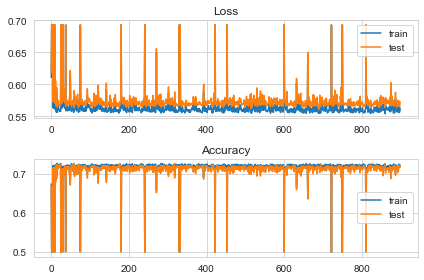

In [123]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(train_loss.values(), label='train')
plt.plot(test_loss.values(), label='test')
plt.legend()
# plot mse during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(train_accuracy.values(), label='train')
plt.plot(test_accuracy.values(), label='test')
plt.legend()
plt.tight_layout()
plt.show()

In [124]:
%%time
model = create_model_2(**grid.best_params_)

Wall time: 28.9 ms


In [126]:
print(f"Train vs Test Loss is: {min(history.history['loss'])} -- {min(history.history['val_loss'])}")
print(f"Train vs Test Accuracy is: {max(history.history['accuracy'])} -- {max(history.history['val_accuracy'])}")

Train vs Test Loss is: 0.5455096960067749 -- 0.5522812604904175
Train vs Test Accuracy is: 0.7308179140090942 -- 0.7265822887420654


In [127]:
%%time
model.evaluate(X_test, y_test, batch_size=10)

909/909 [==============================] - 0s 344us/step - loss: 0.5579 - accuracy: 0.7255
Wall time: 1.27 s


[0.5579054951667786, 0.7254815697669983]

In [128]:
predictions = model.predict(data_standardized_test)
y_pred_ann2 = [round(x[0]) for x in predictions]

## Decision Tree

In [111]:
X = data_discretized.drop(columns=['Disease'])

y = data_discretized['Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1,
    shuffle=True,
    stratify=y
)

In [112]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 4, 5, 10, 20],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 3, 4, 5, 10],
    'max_leaf_nodes': [2, 3, 4, 5, 10, 20, 25, 30]
}

Training data size is (36336, 11), and Validation data size is (9085, 11)

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits
Training set best score: 0.7230891306633495

Best parameters found: 
 {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Fitting best params to validation data set... 

Fitting complete

Confusion matrix:
 [[3512 1024]
 [1479 3070]]

Classification report:
               precision    recall  f1-score   support

           0       0.70      0.77      0.74      4536
           1       0.75      0.67      0.71      4549

    accuracy                           0.72      9085
   macro avg       0.73      0.72      0.72      9085
weighted avg       0.73      0.72      0.72      9085


Recall score:  0.6748735985930974

Precision score:  0.7498778700537372

F1 score:  0.7104014809672569

Accuracy score:  0.7244909190974134

ROC AUC: 0.7863804592206438


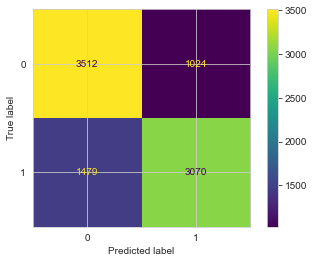

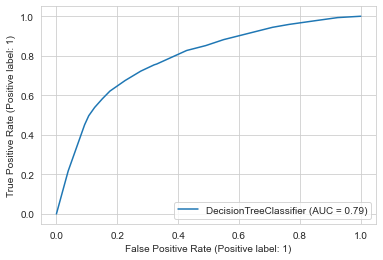

In [113]:
best_params_dt = model_implementation('DecisionTreeClassifier', data_discretized, param_grid=param_grid)

### Prediction

In [114]:
%%time
clf_test_unseen = DecisionTreeClassifier(**best_params_dt)

Wall time: 0 ns


In [115]:
X = data_discretized.drop(columns=['Disease'])

y = data_discretized['Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1,
    shuffle=True,
    stratify=y
)

In [116]:
%%time
clf_test_unseen.fit(X_train, y_train)

Wall time: 33.9 ms


DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=20)

In [117]:
y_pred_dt = clf_test_unseen.predict(data_discretized_test)

### Prediction Results

In [129]:
predictions = pd.DataFrame(zip(id_, y_pred_dt, y_pred_ann0, y_pred_ann1, y_pred_ann2), columns=['ID', 'DT', 'ANN0', 'ANN1', 'ANN2'])

In [130]:
predictions.to_csv('predictions.csv', index=False)

In [131]:
for col in predictions.columns[1:]:
    print(f"{col}: {predictions[col].value_counts()}")

DT: 1    20966
0       34
Name: DT, dtype: int64
ANN0: 0    11691
1     9309
Name: ANN0, dtype: int64
ANN1: 0    13939
1     7061
Name: ANN1, dtype: int64
ANN2: 0    20975
1       25
Name: ANN2, dtype: int64


## Performance Table

| Classifier                                  | Tuned Hyperparameters                                                                                                            | Accuracy | Build Time | Notes                     |
|---------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------|----------|------------|---------------------------|
| Random Forest                               | bootstrap': True, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300    | 73.0%    | 4-5s       |                           |
| Artificial Neural Network (0 hidden layers) | activation': 'sigmoid', 'optimizer': 'Adam', loss='binary_crossentropy', epochs=50/100, batch_size=5                             | 72.9%    | 1-2min     | with 50 iterations/epochs |
| Artificial Neural Network (2 hidden layers) | activation': 'relu', 'neurons': 15, 'optimizer': 'Adam', loss='binary_crossentropy', epochs=50/100, batch_size=5                 | 72.7%    | 1-2min     | with 50 iterations/epochs |
| Artificial Neural Network (1 hidden layer)  | activation': 'tanh', 'neurons': 10, 'optimizer': 'RMSprop', loss='binary_crossentropy', epochs=50/100, batch_size=5              | 72.4%    | 1-2min     | with 50 iterations/epochs |
| Decision Tree                               | 'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2                     | 72.0%    | 30-40ms    |                           |
| K Nearest Neighbor                          | algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'                         | 72.0%    | 300-400ms  |                           |
| Naïve Bayes (Gaussian)                      | None                                                                                                                             | 71.0%    | Negligible |                           |
| Gradient Boost                              | criterion': 'mse', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 1000 | 69.0%    | 50-60s     |                           |


* s -- seconds
* ms -- milliseconds
* min -- minutes

## Conclusion

* We can see that Decision Tree predicted almost all the values as True/Positive and had a similar accuracy score as that of the artificial neural networks. Similarly, ANN2 predicted almost all the values as False/Negative. A previous run of ANN2 with the activation function as 'tanh' and optimizer as 'RMSprop' showed similar results to that of ANN0 and ANN1.
* As we move from zero hidden layers to one and two hidden layers, we can see that the number of negative predictions increase in the unseen test dataset, despite no change in the accuracy metric with the addition of hidden layers.
* From the results, additional hyperparameter tuning can be done on the Artificial Neural Networks (ANN), specifically regularization and learning rate. Adjusting the weights and bias can lead to an increase in accuracy without much change in the other hyperparameters themselves.
* There is a vast difference in training time for decision tree versus neural networks. Neural networks take much longer to build as compared to Decision Trees. This a tradeoff to consider when deploying models for pratical use.
* Additionally, it is difficult to explain the 'behind the scenes' workings of an artificial neural network, whereas the decisions made by the decision tree classifier can be clearly explained and visually mapped through an easy to follow feature hierarchy chart.
* Gradient boost could perform better with more tuning.
* From the overall results of all the algorithms, ANN0 is the most reliable with the highest test score and a reasonable spread between the two binary class labels.

## Additional Considerations

* Look into other hyper parameters such as impurity (which is set to to it's default settings)
* Convert standardized data to positive values for Complement and Multinomial NB, although this would likely have a negative impact on the results
* Drop correlated features
* Add function to define ranges for results of random search to be passed to grid search
* Add function that keeps track of processing time for random and grid search
* Add loss metrics
* Remove more or all outliers from High and Low Blood Pressure
* Implement bagging with decision tree 
* Decision Tree feature importance
* Decision Tree feature hierarchy chart
* Regularization (L1, L2, L1 & L2)
    * Kernel
    * Bias
    * Activity
* Look at epochs and error minimization (plot chart to identify optimum learning rate)
* Compare confusion matrix values for recall scores (generate confusion matrix for keras classifier)

***Notes***
 * Choosing max_features < n_features leads to a reduction of variance and an increase in bias.

## References
 * https://machinelearningmastery.com/classification-as-conditional-probability-and-the-naive-bayes-algorithm/
 * https://stackoverflow.com/questions/56397128/roc-auc-score-is-different-while-calculating-using-predict-vs-predict-proba
 * https://datascience.stackexchange.com/questions/40940/why-is-sklearn-metrics-roc-auc-score-seemingly-able-to-accept-scores-on-any-sc
 * https://stackoverflow.com/questions/47742698/how-does-sklearn-calculates-the-area-under-the-roc-curve-for-a-binary-classifier
 * https://stackoverflow.com/questions/65398299/proper-inputs-for-scikit-learn-roc-auc-score-and-roc-plot
 * https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
 * https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
 * https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html#sphx-glr-auto-examples-preprocessing-plot-discretization-py
 * https://stackoverflow.com/questions/39828535/how-to-tune-gaussiannb
 * https://stackoverflow.com/questions/51194627/python-naive-bayes-with-cross-validation-using-gaussiannb-classifier
 * https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

 * https://towardsdatascience.com/multi-layer-neural-networks-with-sigmoid-function-deep-learning-for-rookies-2-bf464f09eb7f
 * https://machinelearningmastery.com/
 * https://www.analyticsvidhya.com/blog/2021/05/artificial-neural-networks-25-questions-to-test-your-skills-on-ann/
 * https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
 * https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
 * https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
 * https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
 * https://realpython.com/python-ai-neural-network/#machine-learning